In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import math
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from Caulimate.Data.CESM2.dataset import CESM2_grouped_dataset
from Caulimate.Utils.Visualization import quick_map
from Caulimate.Utils.Metrics import MAE, MSE, MAPE, RMSE, R_squared
from Caulimate.Utils.Tools import makedir, check_tensor

In [2]:
XR_DATA_PATH = "/l/users/minghao.fu/dataset/CESM2/CESM2_pacific_grouped_SST.nc"
NUM_AREA = 1
TIME_IDX = 1000
SAVE_DIR = './Figures'

makedir(SAVE_DIR)
full_dataset = CESM2_grouped_dataset(XR_DATA_PATH, num_area=NUM_AREA)
dataset = full_dataset[0]

--- Area 0 has 104 groups
--- Number of areas: 10, Number of groups: 1000


In [3]:

full_data = dataset.full_xr_ds.to_array()
data = dataset.xr_ds
center2regions_dict = {}
for idx in dataset.group_inds:
    selected_group = full_data.where(full_data.group_index == idx, drop=True)
    center2regions_dict[idx] = list(zip(selected_group.nlon.values, selected_group.nlat.values))

data = dataset.X  # Random data for example

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Create dataset (t-1, t)
def create_dataset(data):
    X, y = [], []
    for i in range(1, len(data)):
        X.append(data[i-1])
        y.append(data[i])
    return np.array(X), np.array(y)

X, y = create_dataset(data)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

In [4]:

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return x

class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, nhead, nlayers):
        super(TransformerModel, self).__init__()
        self.hidden_size = hidden_size
        self.input_embedding = nn.Linear(input_size, hidden_size)
        self.positional_encoding = nn.Parameter(torch.rand(1, hidden_size))
        self.transformer = nn.TransformerEncoder(nn.TransformerEncoderLayer(hidden_size, nhead), nlayers)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.input_embedding(x) * math.sqrt(self.hidden_size)
        x = x + self.positional_encoding
        x = self.transformer(x)
        x = self.output(x)
        return x

In [5]:
input_size = X_train.shape[1]  # Should be equal to dim
hidden_size = 50
output_size = y_train.shape[1]  # Should be equal to dim
extent = [-140, -70, -10, 10]
vmin = -2
vmax = 2
cmap = plt.cm.RdBu_r
IMAGE_IDX = 0

y_lst = []
predicted_lst = []
diff_xr_lst = []

for model in [MLP(input_size, hidden_size, output_size), nn.Linear(input_size, output_size), MLP(input_size, hidden_size // 2, output_size)]:
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Train the model
    epochs = 10000
    for epoch in range(epochs):
        model.train()
        
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % (epochs // 2) == 0:
            print(f'Epoch [{epoch+1}/{epochs}], MSE Loss: {loss.item():.4f}')

    model.eval()

    # Calculate training loss
    train_outputs = model(X_train)
    train_loss = criterion(train_outputs, y_train).item()

    # Calculate test loss
    test_outputs = model(X_test)

    train_predict = model(X_train).detach().numpy()
    test_predict = model(X_test).detach().numpy()

    # train_predict = scaler.inverse_transform(train_predict)
    # y_train = scaler.inverse_transform(y_train.numpy())
    test_predict = scaler.inverse_transform(test_predict)
    y_test_recover = scaler.inverse_transform(y_test.numpy())
    forecast_xr = dataset.area_xr_da.isel(time=TIME_IDX).copy()
    forecast_temperature = test_predict[TIME_IDX]
    for i, group_ind in enumerate(dataset.group_inds):
        forecast_xr.values = np.where(dataset.area_xr_da.group_index == group_ind, forecast_temperature[i], forecast_xr.values)
    y_xr = dataset.area_xr_da.isel(time=TIME_IDX).copy()
    y_temperature = y_test_recover[TIME_IDX]
    for i, group_ind in enumerate(dataset.group_inds):
        y_xr.values = np.where(dataset.area_xr_da.group_index == group_ind, y_temperature[i], y_xr.values)

    test_mae = MAE(test_predict, y_test_recover) 
    test_mape = MAPE(test_predict, y_test_recover)
    test_R_squared = R_squared(test_predict, y_test_recover)
    test_rmse = RMSE(test_predict, y_test_recover)

    #print(f'--- [Training Loss] RMSE: {np.sqrt(train_loss):.4f}')
    print(f'--- [Test Loss] MAE: {test_mae:.4f} | MAPE: {test_mape:.4f} | R^2: {test_R_squared:.4f} | RMSE: {test_rmse:.4f}')

    predicted_lst.append(test_predict)
    y_lst.append(y_test_recover)
    diff_xr_lst.append(forecast_xr - y_xr)

    forecast_xr = dataset.area_xr_da.isel(time=TIME_IDX + 1).copy()
    for i, group_ind in enumerate(dataset.group_inds):
        forecast_xr.values = np.where(dataset.area_xr_da.group_index == group_ind, forecast_temperature[i], forecast_xr.values)
    y_xr = dataset.area_xr_da.isel(time=TIME_IDX + 1).copy()
    y_temperature = y_test_recover[TIME_IDX + 1]
    for i, group_ind in enumerate(dataset.group_inds):
        y_xr.values = np.where(dataset.area_xr_da.group_index == group_ind, y_temperature[i], y_xr.values)

    predicted_lst.append(test_predict)
    y_lst.append(y_test_recover)
    diff_xr_lst.append(forecast_xr - y_xr)

Epoch [5000/10000], MSE Loss: 0.0020
Epoch [10000/10000], MSE Loss: 0.0017
--- [Test Loss] MAE: 0.2822 | MAPE: 0.0111 | R^2: 0.9628 | RMSE: 0.3698
Epoch [5000/10000], MSE Loss: 0.0018
Epoch [10000/10000], MSE Loss: 0.0018
--- [Test Loss] MAE: 0.2769 | MAPE: 0.0108 | R^2: 0.9629 | RMSE: 0.3707
Epoch [5000/10000], MSE Loss: 0.0021
Epoch [10000/10000], MSE Loss: 0.0019
--- [Test Loss] MAE: 0.2903 | MAPE: 0.0113 | R^2: 0.9595 | RMSE: 0.3837


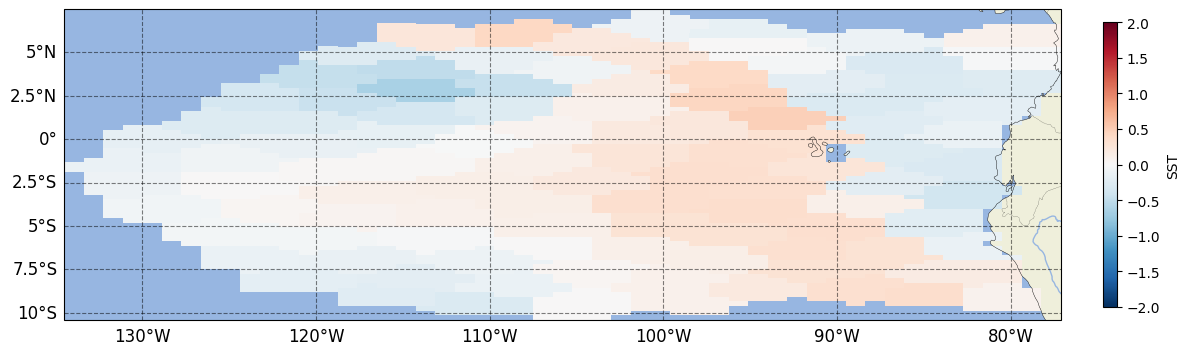

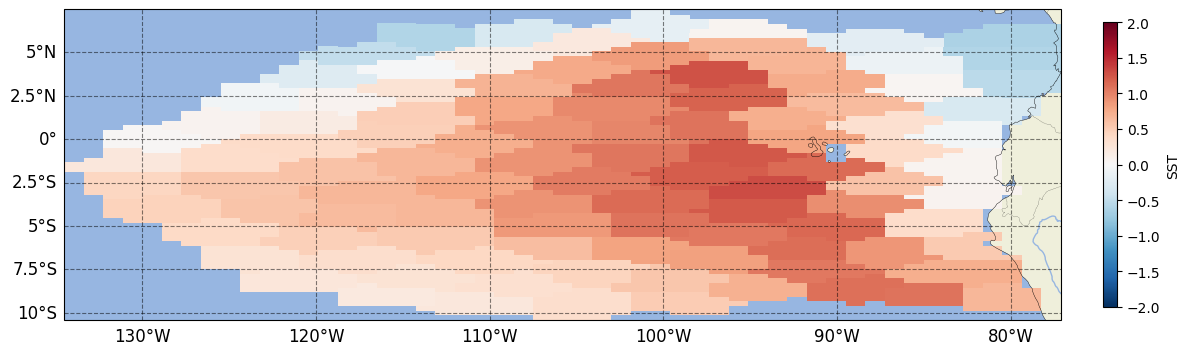

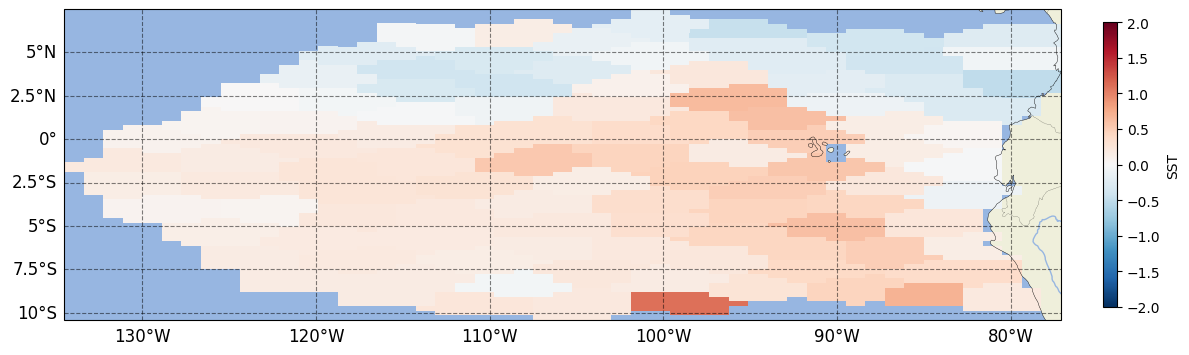

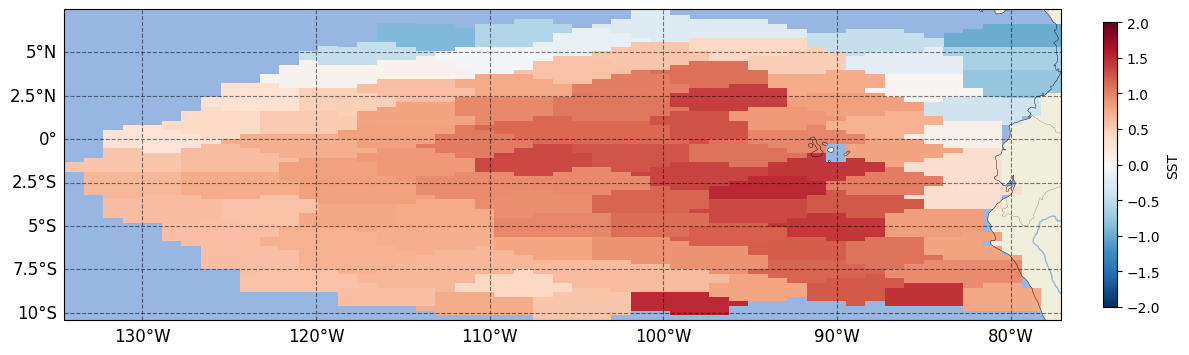

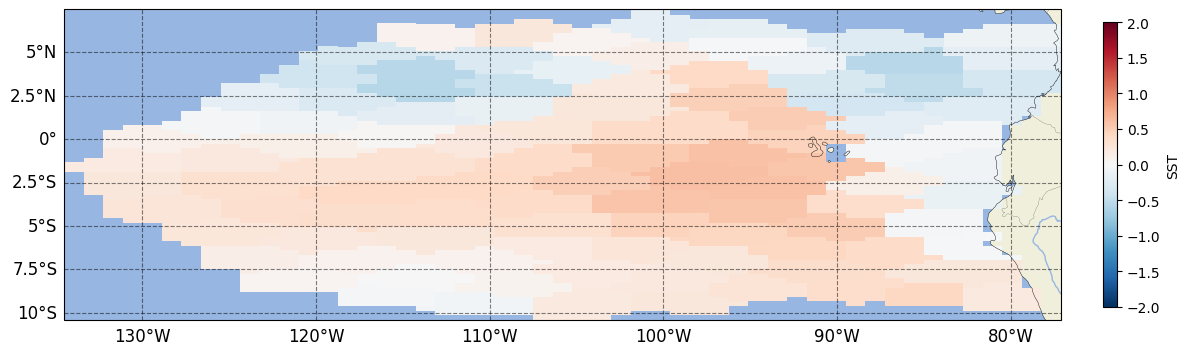

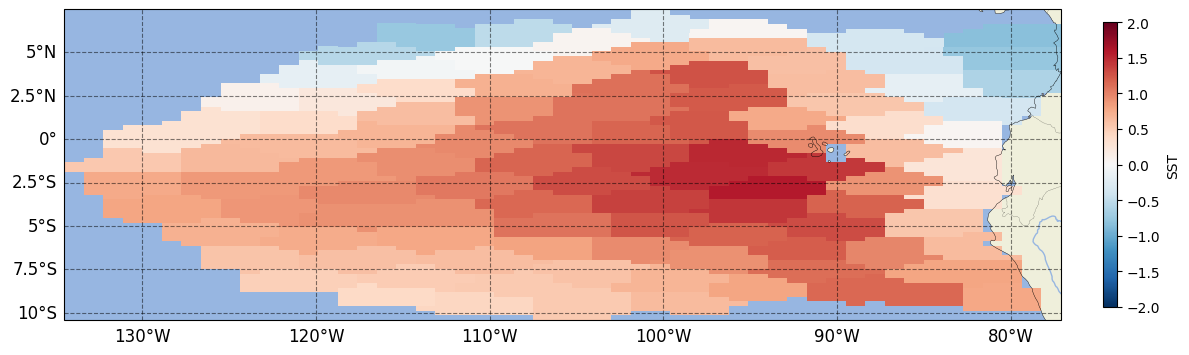

In [24]:
IMAGE_IDX = 0 
for _, _, diff_xr in zip(predicted_lst, y_lst, diff_xr_lst):
    fig, ax = plt.subplots(figsize=(12, 12), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cartopy.feature.LAND)
    ax.add_feature(cartopy.feature.OCEAN)
    ax.add_feature(cartopy.feature.COASTLINE,linewidth=0.3)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':',linewidth=0.3)
    ax.add_feature(cartopy.feature.LAKES, alpha=0.5)
    ax.add_feature(cartopy.feature.RIVERS)
    ax.set_xlabel('Longitude', fontsize=12)
    ax.set_ylabel('Latitude')
    ax.set_title('Sea Surface Temperature (SST)')
    gl = ax.gridlines(draw_labels=True, color='black', alpha=0.5, linestyle='--')
    gl.top_labels = False  # Disable labels at the top
    gl.right_labels = False  # Disable labels on the right
    gl.xlabel_style = {'size': 12}
    gl.ylabel_style = {'size': 12}
    cbar_kwargs = {
        'fraction': 0.0135,  # Adjust as needed
        'pad': 0.04,  # Adjust as needed
    }
    # ax.set_extent(extent)
    diff_xr.plot(x='lon', y='lat', transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, ax=ax, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.tight_layout()
    plt.savefig(f'./Figures/CESM2ForecastDiff{IMAGE_IDX}.pdf', bbox_inches='tight', dpi=300, format='pdf')  
    IMAGE_IDX += 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


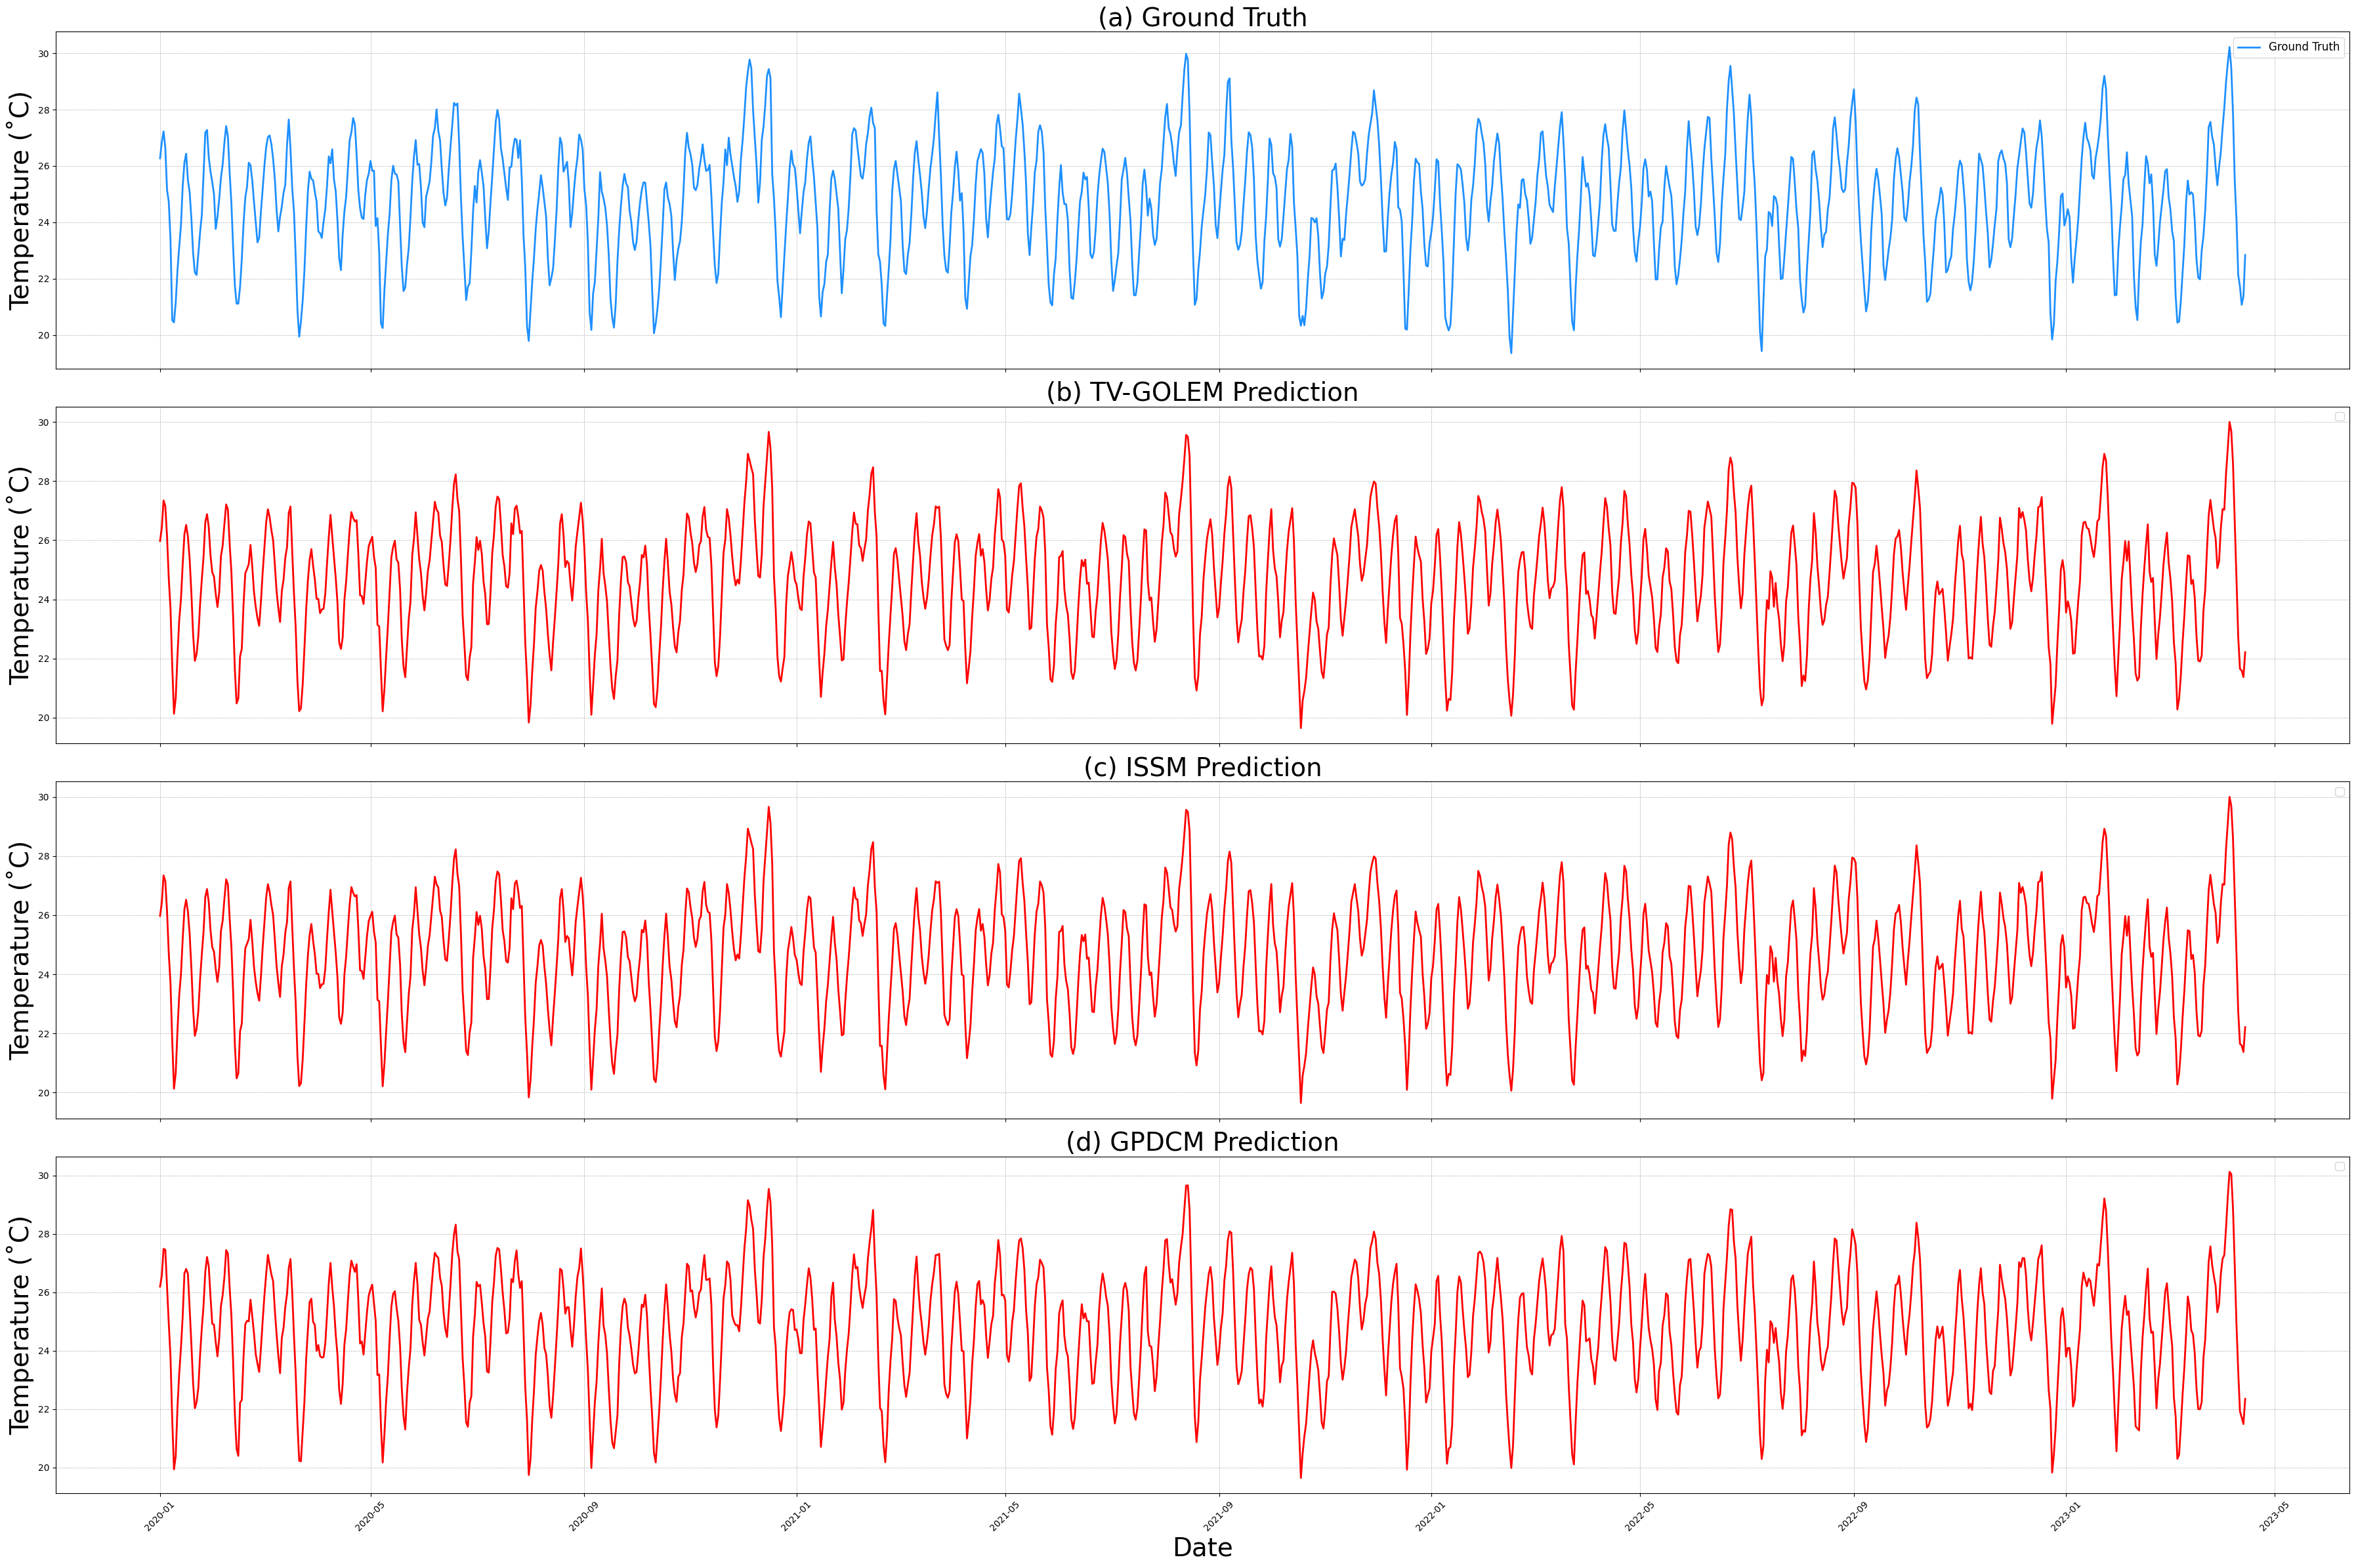

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


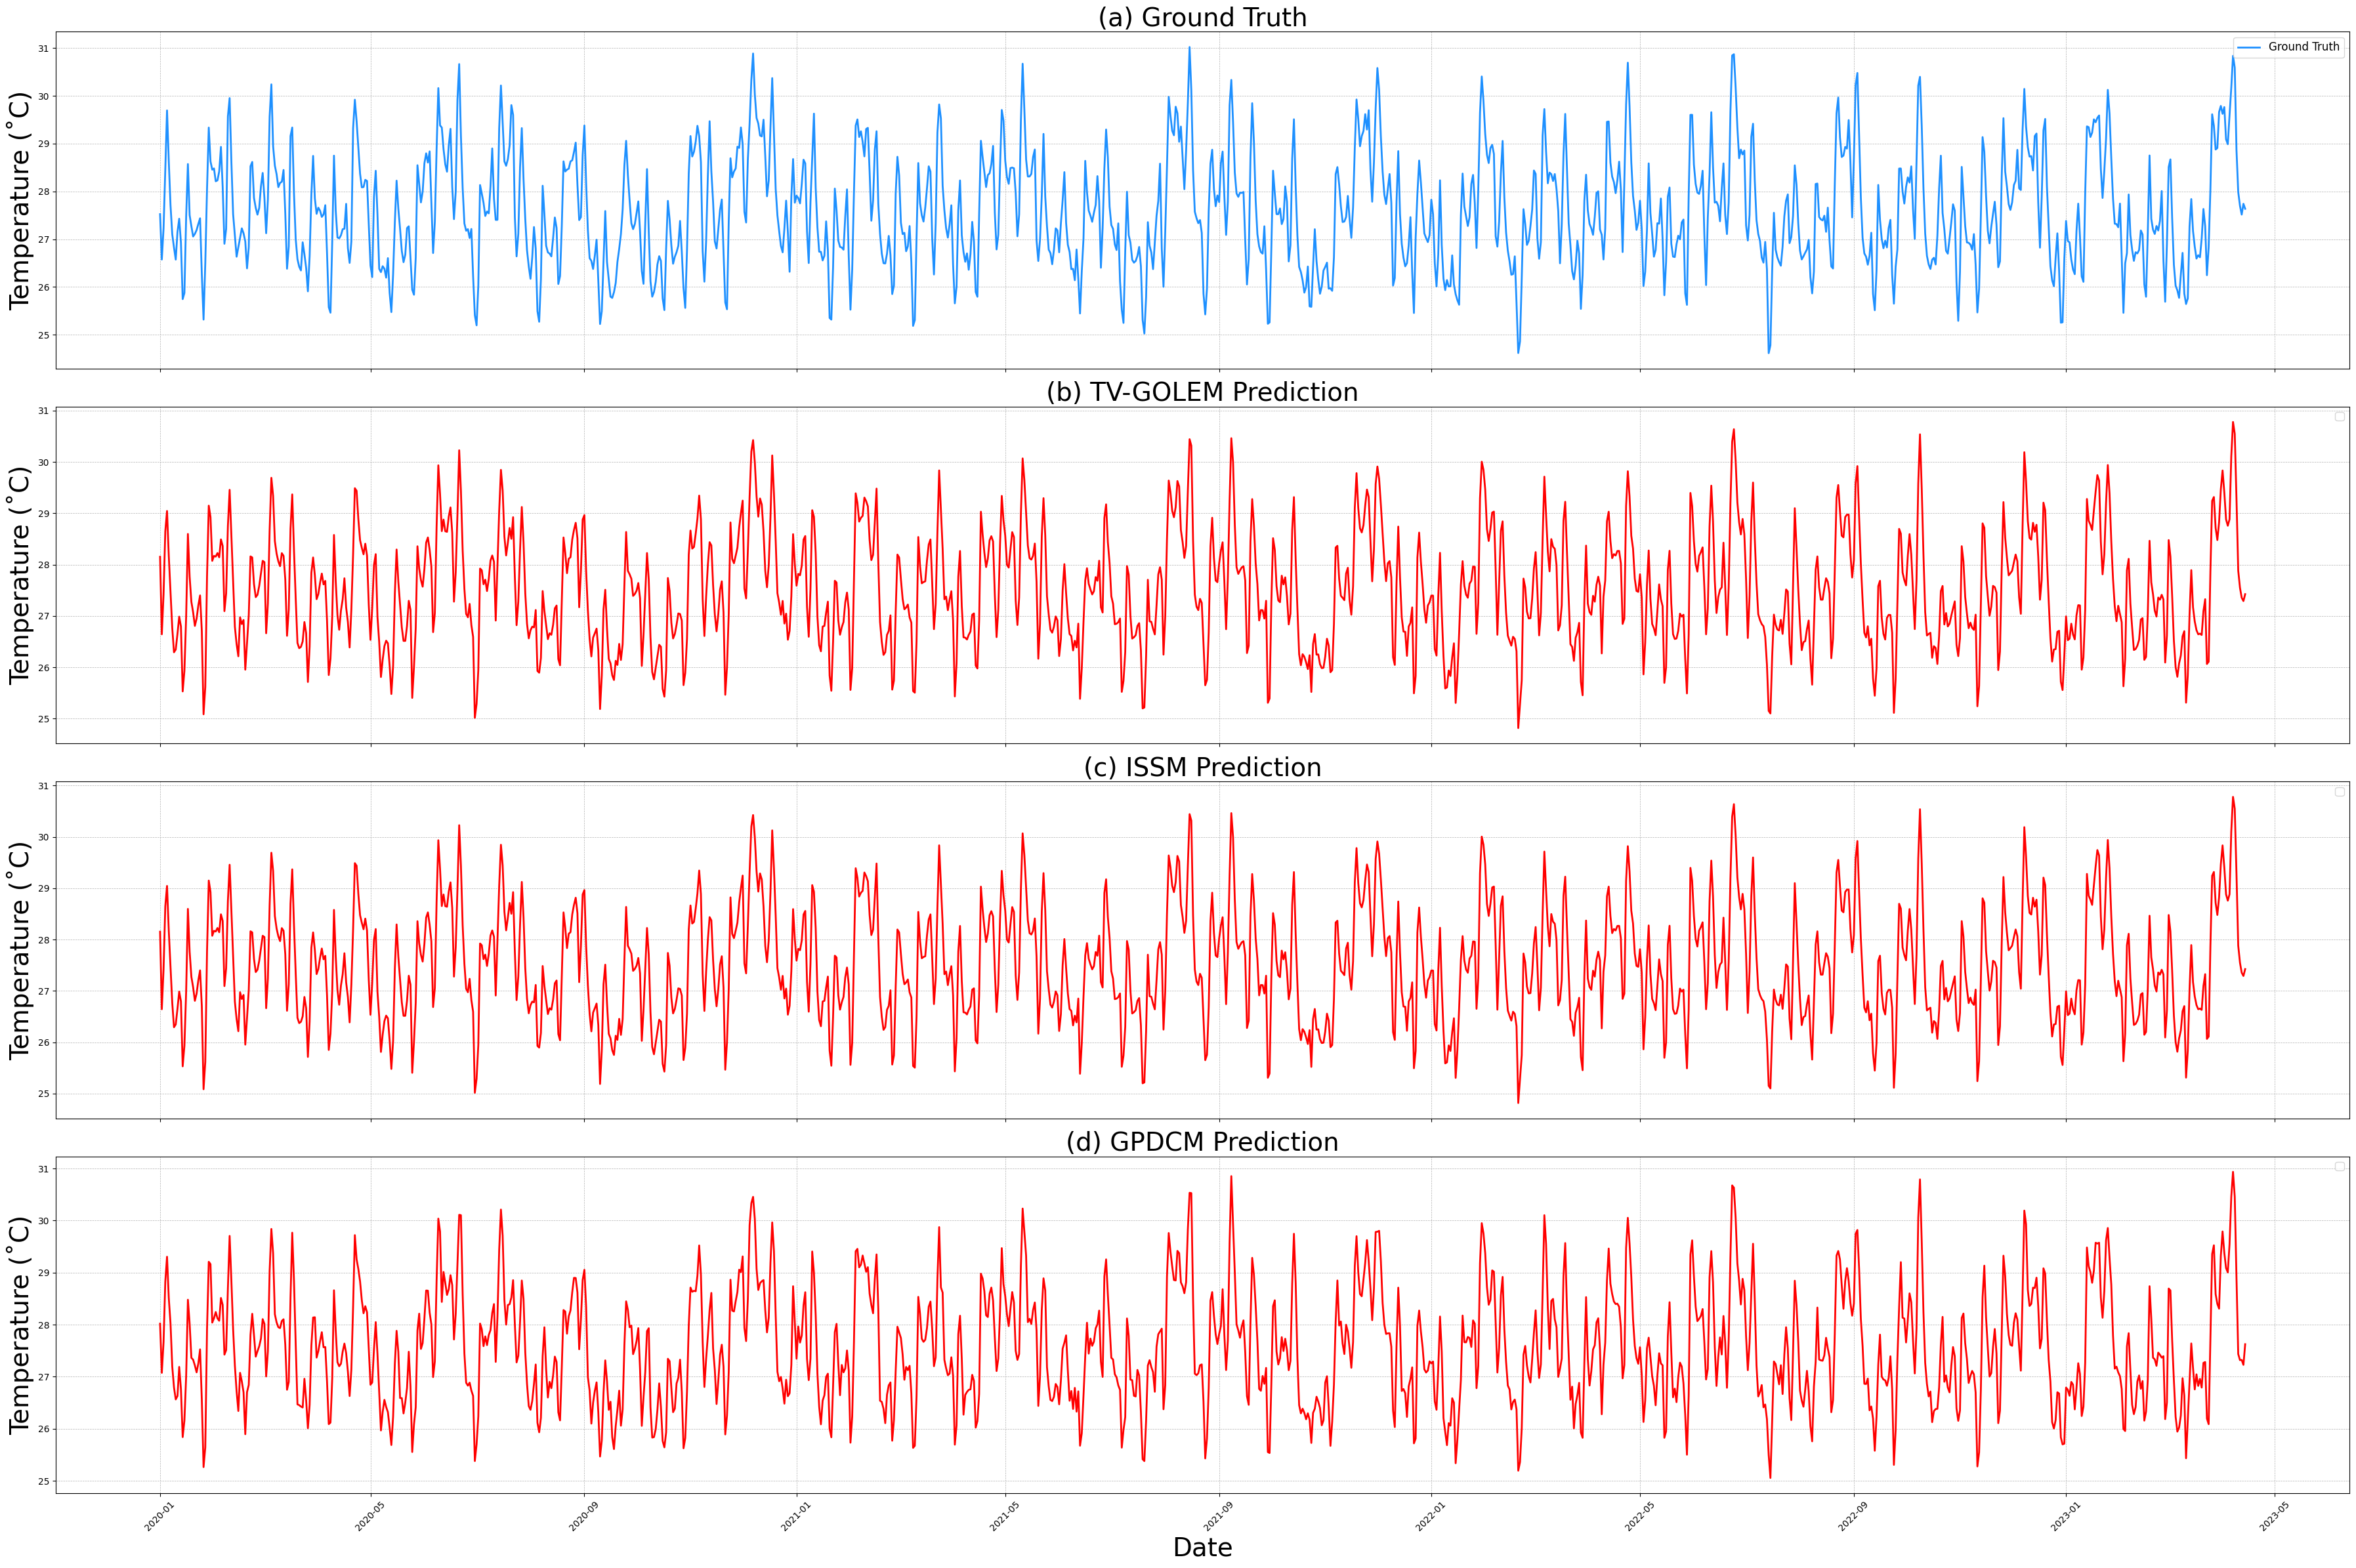

In [23]:
font_size=28

for center_idx in [11, 100]:
    fig, axs = plt.subplots(4, 1, figsize=(36, 24), sharex=True)

    # Generate sample time-series data
    np.random.seed(0)
    data_gt = y_lst[0][:, center_idx]
    date_range = pd.date_range(start='2020-01-01', periods=len(data_gt), freq='D')

    # Plotting
    axs[0].plot(date_range, data_gt, label='Ground Truth', color='dodgerblue', linewidth=2, linestyle='-')
    axs[0].set_title('(a) Ground Truth', fontsize=font_size)
    

    axs[1].plot(date_range, predicted_lst[0][:, center_idx], color='red', linewidth=2)
    axs[1].set_title('(b) TV-GOLEM Prediction', fontsize=font_size)

    axs[2].plot(date_range, predicted_lst[1][:, center_idx], color='red', linewidth=2)
    axs[2].set_title('(c) ISSM Prediction', fontsize=font_size)

    axs[3].plot(date_range, predicted_lst[2][:, center_idx], color='red', linewidth=2)
    axs[3].set_title('(d) GPDCM Prediction', fontsize=font_size)
    axs[3].grid(True, which='both', linestyle='--', linewidth=0.5)
    axs[3].legend(fontsize=font_size)
    axs[3].tick_params(axis='x', rotation=45)
    axs[i].set_xlabel('Date', fontsize=font_size)

    for i in range(len(axs)):
        
        axs[i].set_ylabel('Temperature (˚C)', fontsize=font_size)

        # Adding a grid
        axs[i].grid(True, which='both', linestyle='--', linewidth=0.5)

        # Adding a legend
        axs[i].legend(fontsize=12)

        # Rotate date labels for better readability
        axs[i].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.savefig('./Figures/CESM2Forecast{}.pdf'.format(center_idx), bbox_inches='tight', dpi=300, format='pdf')  
    plt.show()

In [8]:
data['Ground Truth'].shape

(1200,)